In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import util
from util import inv_phi_range
from util import FWHM
from util import calculate_phi
import model as m

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


/home/diptarko/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
teacher_hidden_neurons = 256
student_hidden_neurons = 8
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
ap_fixed       = [18, 5]
lr = 1e-4
device = 0
n_epochs     = 100
batch_size   = 1024

In [3]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


train_len =  619108
Train df shape: (619108, 34)
Test  df shape: (32585, 34)
X train shape: (619108, 5)
Y train shape: (619108, 3)
X test  shape: (32585, 5)
Y test  shape: (32585, 3)


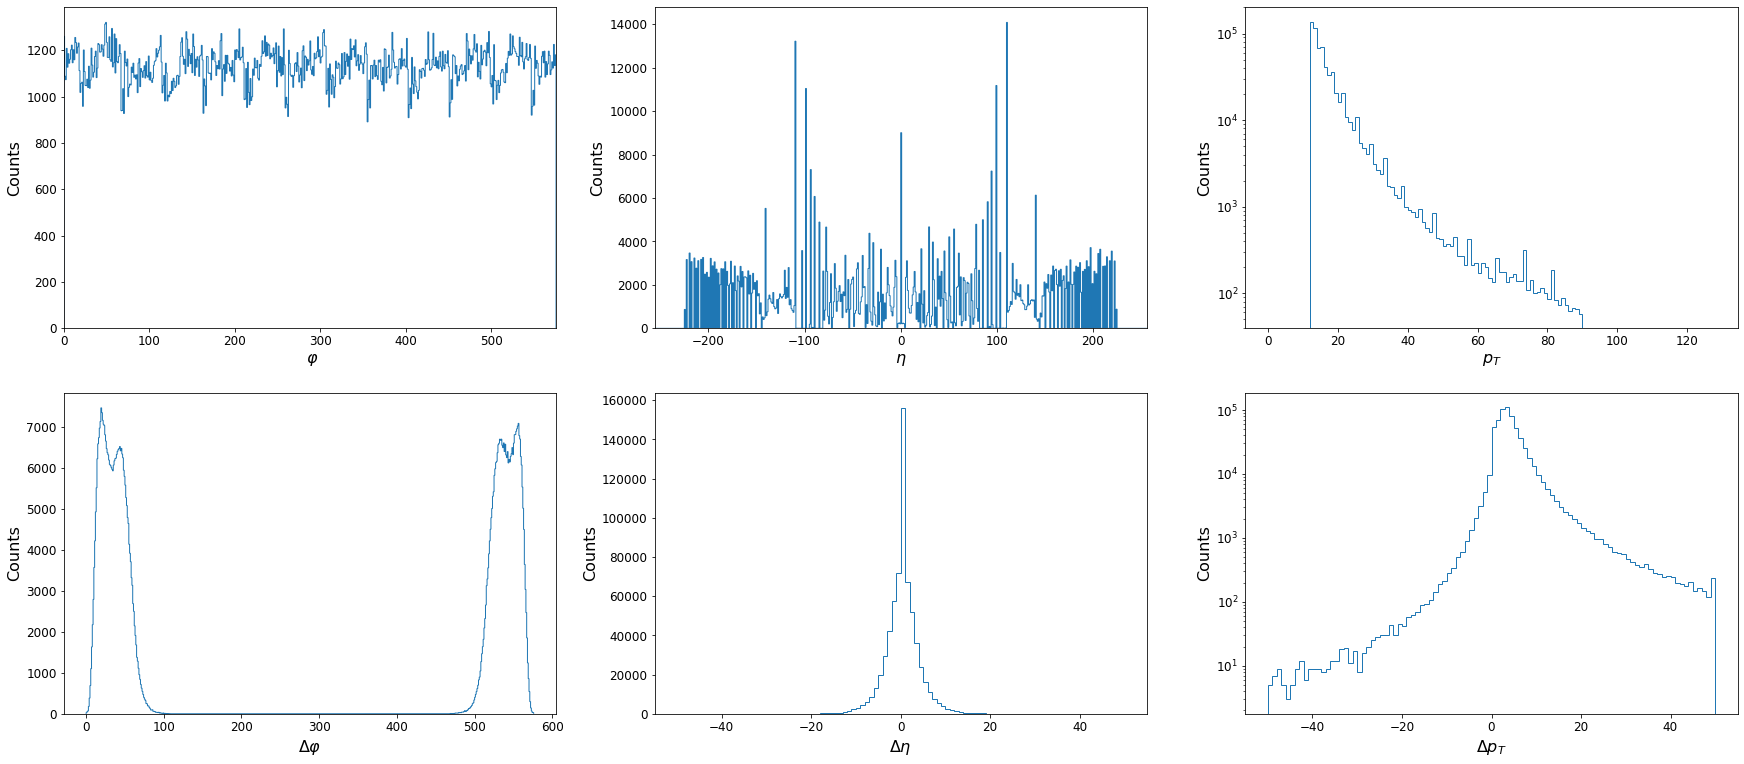

In [4]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data
util.plot_data(df_base)

In [5]:
idx_barrel = np.abs(df_base["etaVtxRecoMu1"]) <= 0.8
idx_overlap = (np.abs(df_base["etaVtxRecoMu1"]) > 0.8) * (np.abs(df_base["etaVtxRecoMu1"]) < 1.24)
idx_endcap = (np.abs(df_base["etaVtxRecoMu1"]) > 1.24) * (np.abs(df_base["etaVtxRecoMu1"]) < 20)

In [6]:
df_barrel = df_base[idx_barrel]
df_overlap = df_base[idx_overlap]
df_endcap = df_base[idx_endcap]


In [7]:
df_barrel = util.apply_cut(df_barrel, 5.5, 45)
train_data_barrel, test_data_barrel, df_train_barrel, df_test_barrel = util.preprocess_data(df_barrel)
x_train_barrel, y_train_barrel = train_data_barrel
x_test_barrel, y_test_barrel = test_data_barrel

df_overlap = util.apply_cut(df_overlap, 5.5, 45)
train_data_overlap, test_data_overlap, df_train_overlap, df_test_overlap = util.preprocess_data(df_overlap)
x_train_overlap, y_train_overlap = train_data_overlap
x_test_overlap, y_test_overlap = test_data_overlap

df_endcap = util.apply_cut(df_endcap, 5.5, 45)
train_data_endcap, test_data_endcap, df_train_endcap, df_test_endcap = util.preprocess_data(df_endcap)
x_train_endcap, y_train_endcap = train_data_endcap
x_test_endcap, y_test_endcap = test_data_endcap

train_len =  201831
Train df shape: (201831, 34)
Test  df shape: (10623, 34)
X train shape: (201831, 5)
Y train shape: (201831, 3)
X test  shape: (10623, 5)
Y test  shape: (10623, 3)
train_len =  127338
Train df shape: (127338, 34)
Test  df shape: (6702, 34)
X train shape: (127338, 5)
Y train shape: (127338, 3)
X test  shape: (6702, 5)
Y test  shape: (6702, 3)
train_len =  289936
Train df shape: (289936, 34)
Test  df shape: (15260, 34)
X train shape: (289936, 5)
Y train shape: (289936, 3)
X test  shape: (15260, 5)
Y test  shape: (15260, 3)


/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")
/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")
/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


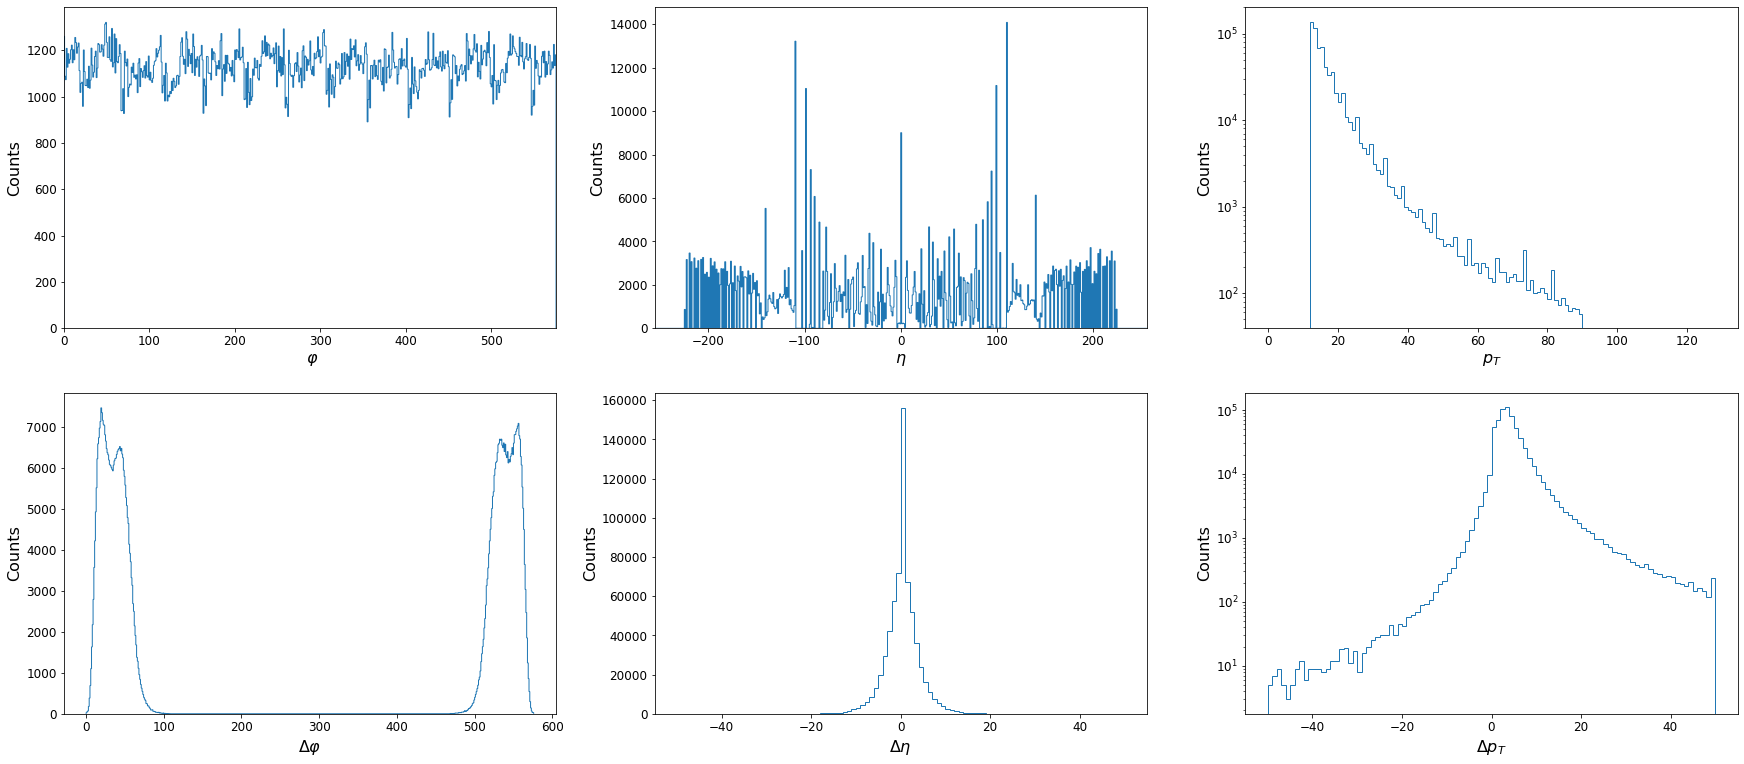

In [8]:
util.plot_data(df_base)

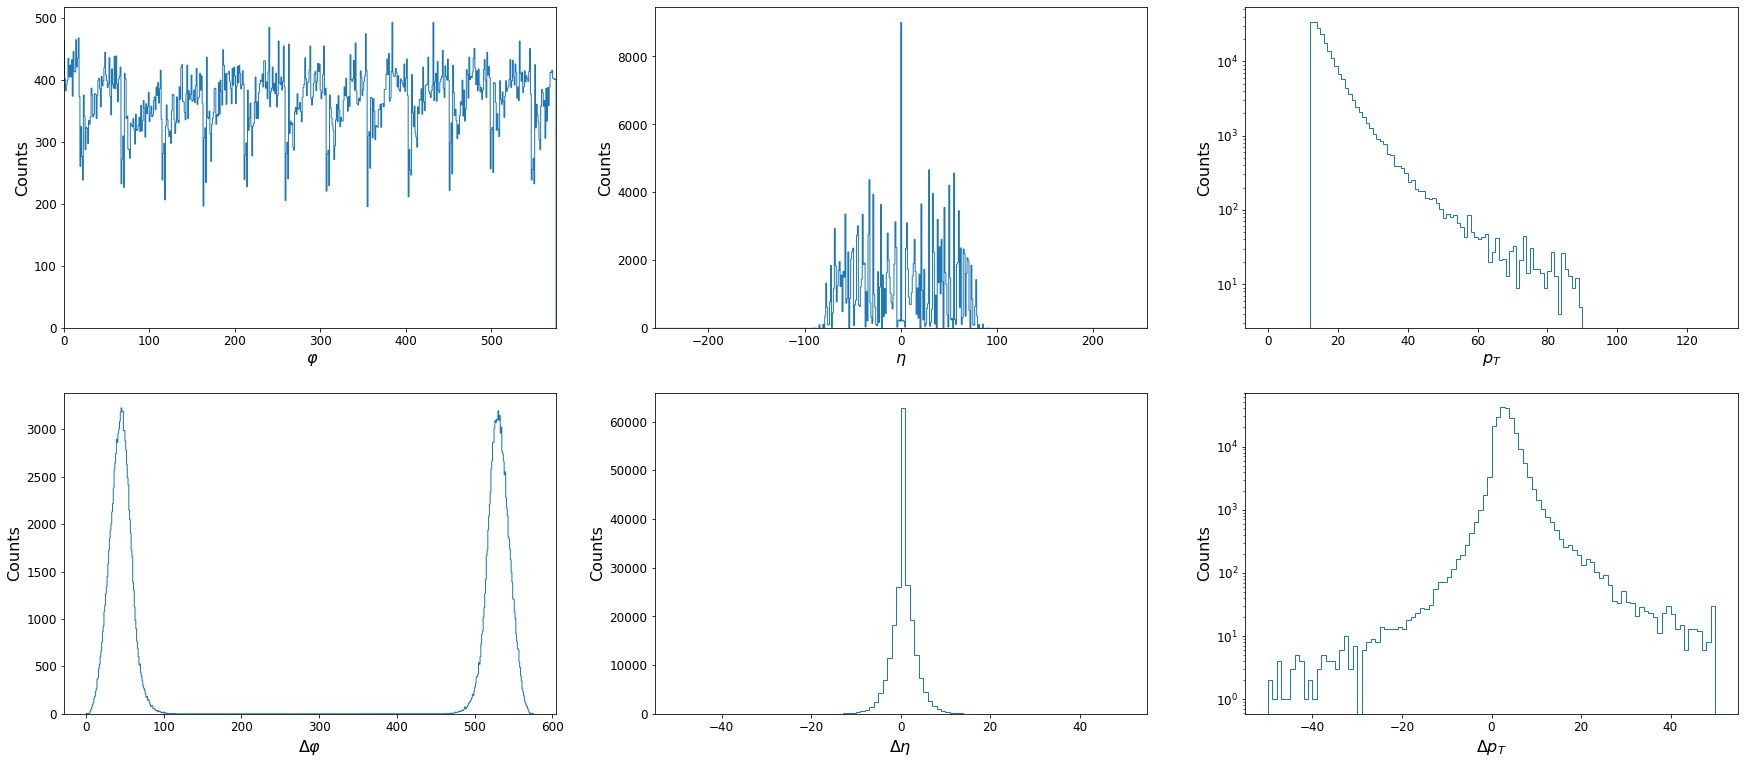

In [9]:
util.plot_data(df_barrel)

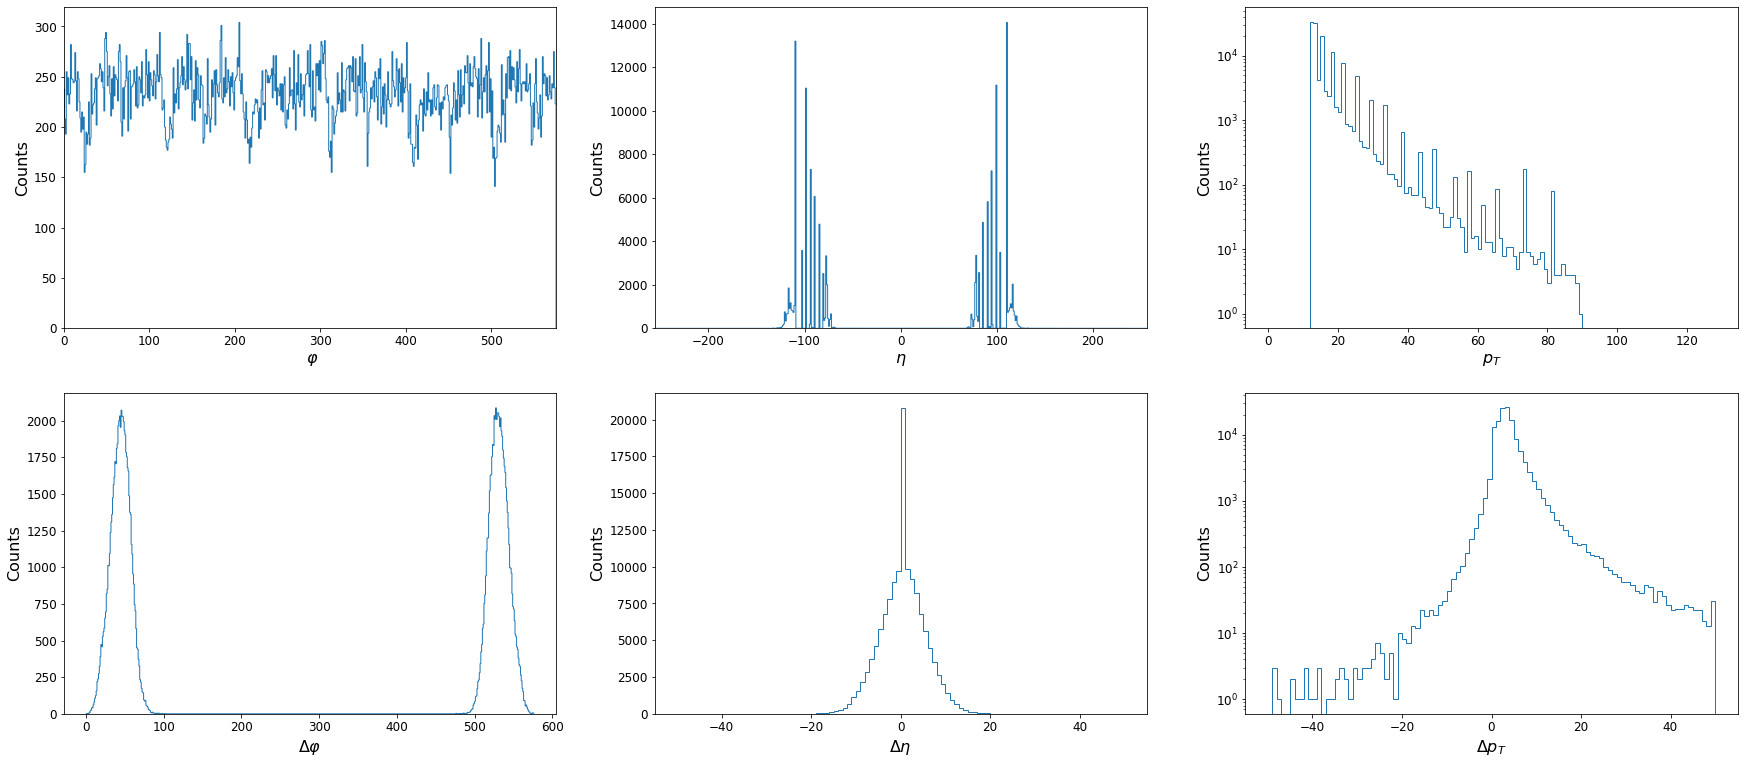

In [10]:
util.plot_data(df_overlap)

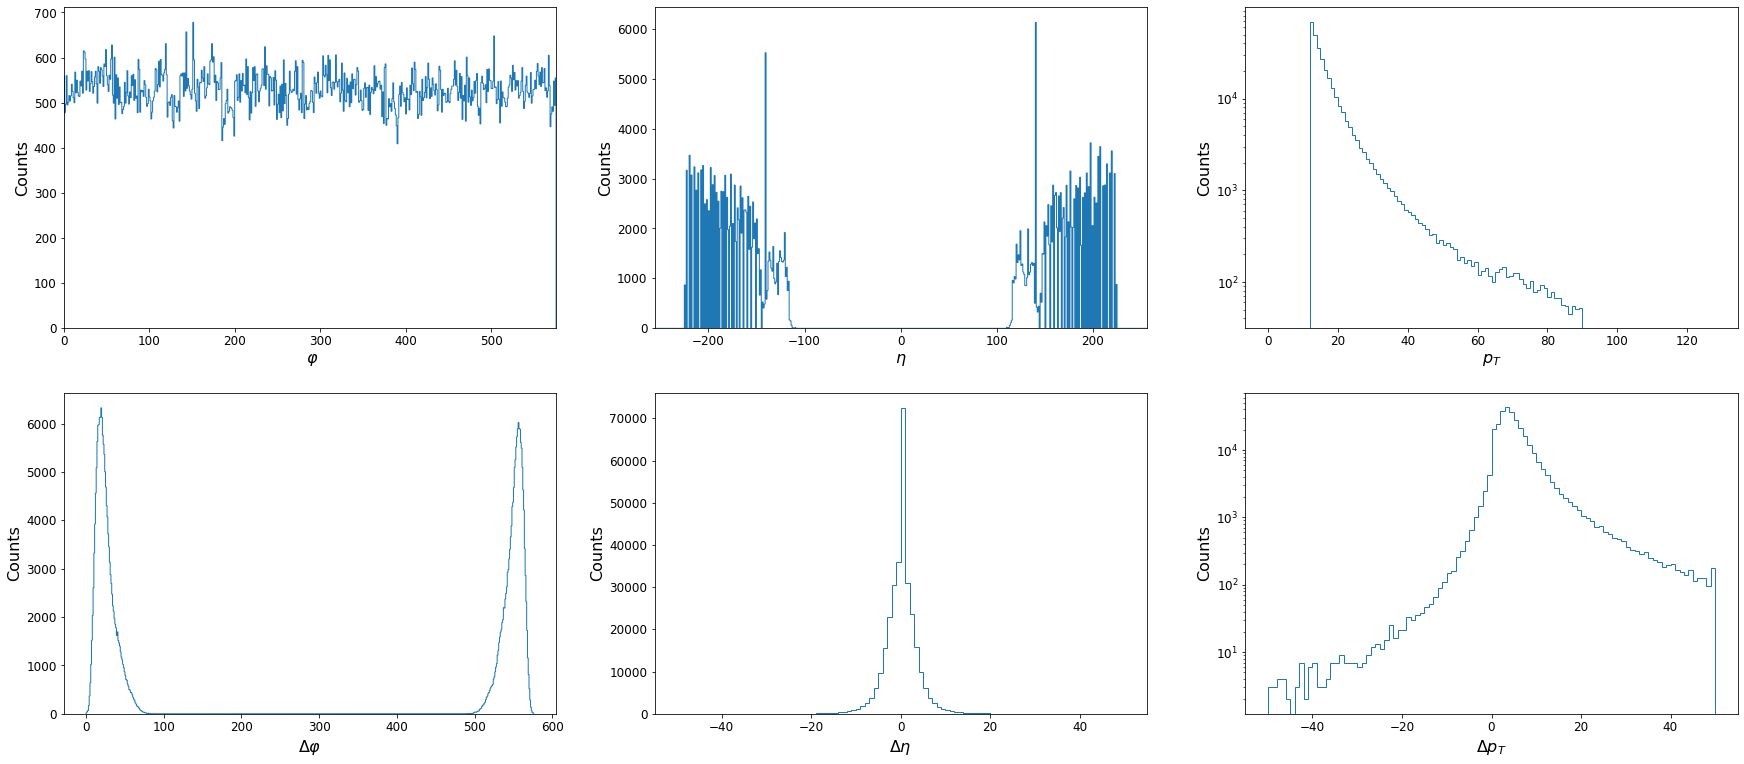

In [11]:
util.plot_data(df_endcap)

In [12]:
model_barrel = m.make_model(hidden_neurons=256,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)
model_overlap = m.make_model(hidden_neurons=256,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)
model_endcap = m.make_model(hidden_neurons=256,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

2023-08-08 17:50:31.409127: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 17:50:32.545847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10393 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-08-08 17:50:32.547298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10407 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [13]:
opt          = Adam(learning_rate=lr)
losses       = ['logcosh', 'logcosh','logcosh']
loss_weights = [1, 1, 1]

early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 20
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                           factor=0.5,
                                                           patience=5,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    "./checkpoints/teacher.h5",
    monitor           = 'val_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
callbacks = [
#     early_stopping,
#                  checkpoint,
             reduce_lr_on_plateu, 
                                 FWHM(x_test,
                                  y_test,
                                  df_test,
                                  use_wandb=False,
                                  verbose=True)]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
        model_barrel.compile(
            loss         = losses,
            loss_weights = loss_weights,
            optimizer    = opt,
        #         metrics=[fwhm]
        )

        model_barrel.fit(
            x_train_barrel, y_train_barrel,
            callbacks=callbacks,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.1,
            shuffle=True,
            verbose = 1
            #callbacks = callbacks.callbacks
        )
model_barrel.save('model_barrel/best')

2023-08-08 17:50:35.878883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
178/178 [==============================] - 4s 9ms/step - loss: 0.1214 - val_loss: 0.1540
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.8720000000000007
FWHM eta NN 0.4400000000000004
FWHM pt-NN 1.4940000000000013
-------------------------------------
-------------------------------------
Epoch 2/100
178/178 [==============================] - 1s 5ms/step - loss: 0.1066 - val_loss: 0.1089
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
----------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0657 - val_loss: 0.0644
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.5440000000000005
FWHM eta NN 0.10400000000000009
FWHM pt-NN 0.6410000000000006
-------------------------------------
-------------------------------------
Epoch 16/100
178/178 [==============================] - 1s 5ms/step - loss: 0.0631 - val_loss: 0.0620
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0375 - val_loss: 0.0371
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.37000000000000033
FWHM eta NN 0.0930000000000002
FWHM pt-NN 0.7220000000000006
-------------------------------------
-------------------------------------
Epoch 30/100
178/178 [==============================] - 1s 6ms/step - loss: 0.0361 - val_loss: 0.0358
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0229 - val_loss: 0.0227
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.3280000000000002
FWHM eta NN 0.08500000000000008
FWHM pt-NN 0.6310000000000006
-------------------------------------
-------------------------------------
Epoch 44/100
178/178 [==============================] - 1s 5ms/step - loss: 0.0222 - val_loss: 0.0224
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0153 - val_loss: 0.0153
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.2950000000000004
FWHM eta NN 0.08000000000000018
FWHM pt-NN 0.5640000000000005
-------------------------------------
-------------------------------------
Epoch 58/100
178/178 [==============================] - 1s 5ms/step - loss: 0.0149 - val_loss: 0.0148
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0111 - val_loss: 0.0112
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.3060000000000004
FWHM eta NN 0.07800000000000018
FWHM pt-NN 0.5690000000000005
-------------------------------------
-------------------------------------
Epoch 72/100
178/178 [==============================] - 1s 5ms/step - loss: 0.0110 - val_loss: 0.0109
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0091 - val_loss: 0.0091
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.30100000000000027
FWHM eta NN 0.07300000000000018
FWHM pt-NN 0.49000000000000044
-------------------------------------
-------------------------------------
Epoch 86/100
178/178 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0091
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
------------------------

178/178 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0088

Epoch 00099: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.27700000000000025
FWHM eta NN 0.07200000000000006
FWHM pt-NN 0.4650000000000005
-------------------------------------
-------------------------------------
Epoch 100/100
178/178 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0088
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-

2023-08-08 17:56:01.440377: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_barrel/best/assets


In [14]:
opt          = Adam(learning_rate=lr)
losses       = ['logcosh', 'logcosh','logcosh']
loss_weights = [1, 1, 1]

early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 20
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                           factor=0.5,
                                                           patience=5,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    "./checkpoints/teacher.h5",
    monitor           = 'val_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
callbacks = [
#     early_stopping,
#                  checkpoint,
             reduce_lr_on_plateu, 
                                 FWHM(x_test,
                                  y_test,
                                  df_test,
                                  use_wandb=False,
                                  verbose=True)]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
        model_overlap.compile(
            loss         = losses,
            loss_weights = loss_weights,
            optimizer    = opt,
        #         metrics=[fwhm]
        )

        model_overlap.fit(
            x_train_overlap, y_train_overlap,
            callbacks=callbacks,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.1,
            shuffle=True,
            verbose = 1
            #callbacks = callbacks.callbacks
        )
model_overlap.save('model_overlap/best')

Epoch 1/100
112/112 [==============================] - 3s 11ms/step - loss: 0.1270 - val_loss: 0.1655
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 1.004000000000001
FWHM eta NN 0.2160000000000002
FWHM pt-NN 1.4120000000000013
-------------------------------------
-------------------------------------
Epoch 2/100
112/112 [==============================] - 1s 5ms/step - loss: 0.1127 - val_loss: 0.1311
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
----------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0878 - val_loss: 0.0871
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.3190000000000002
FWHM eta NN 0.19900000000000007
FWHM pt-NN 0.8210000000000007
-------------------------------------
-------------------------------------
Epoch 16/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0860 - val_loss: 0.0854
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0652 - val_loss: 0.0647
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.3120000000000003
FWHM eta NN 0.17400000000000004
FWHM pt-NN 0.8860000000000009
-------------------------------------
-------------------------------------
Epoch 30/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0639 - val_loss: 0.0634
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0494 - val_loss: 0.0493
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.28700000000000025
FWHM eta NN 0.14900000000000013
FWHM pt-NN 0.7630000000000008
-------------------------------------
-------------------------------------
Epoch 44/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0485 - val_loss: 0.0487
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0387 - val_loss: 0.0387
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.30000000000000027
FWHM eta NN 0.13200000000000023
FWHM pt-NN 0.8670000000000008
-------------------------------------
-------------------------------------
Epoch 58/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0380 - val_loss: 0.0383
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0312 - val_loss: 0.0315
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.27500000000000024
FWHM eta NN 0.13300000000000012
FWHM pt-NN 0.8150000000000007
-------------------------------------
-------------------------------------
Epoch 72/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0308 - val_loss: 0.0309
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0260 - val_loss: 0.0262
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.3240000000000002
FWHM eta NN 0.12500000000000022
FWHM pt-NN 0.8510000000000008
-------------------------------------
-------------------------------------
Epoch 86/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0257 - val_loss: 0.0262
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
--------------------------

112/112 [==============================] - 1s 5ms/step - loss: 0.0221 - val_loss: 0.0226
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.3210000000000004
FWHM eta NN 0.12400000000000022
FWHM pt-NN 0.9030000000000008
-------------------------------------
-------------------------------------
Epoch 100/100
112/112 [==============================] - 1s 5ms/step - loss: 0.0219 - val_loss: 0.0226
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

In [15]:
opt          = Adam(learning_rate=lr)
losses       = ['logcosh', 'logcosh','logcosh']
loss_weights = [1, 1, 1]

early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 20
)
reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                           factor=0.5,
                                                           patience=5,
                                                           verbose=1,
                                                           mode="auto",
                                                           min_delta=0.001,
                                                           cooldown=0,
                                                           min_lr=0)

checkpoint = ModelCheckpoint(
    "./checkpoints/teacher.h5",
    monitor           = 'val_loss',
    verbose           = 1,
    save_best_only    = True,
    save_weights_only = False
)

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
callbacks = [
#     early_stopping,
#                  checkpoint,
             reduce_lr_on_plateu, 
                                 FWHM(x_test,
                                  y_test,
                                  df_test,
                                  use_wandb=False,
                                  verbose=True)]


#     callbacks.append(pruning_callbacks.UpdatePruningStep())

with tf.device(f'/device:GPU:{device}'):    
        model_endcap.compile(
            loss         = losses,
            loss_weights = loss_weights,
            optimizer    = opt,
        #         metrics=[fwhm]
        )

        model_endcap.fit(
            x_train_endcap, y_train_endcap,
            callbacks=callbacks,
            batch_size=batch_size,
            epochs=n_epochs,
            validation_split=0.1,
            shuffle=True,
            verbose = 1
            #callbacks = callbacks.callbacks
        )
model_endcap.save('model_endcap/best')

Epoch 1/100
255/255 [==============================] - 4s 8ms/step - loss: 0.1434 - val_loss: 0.1216
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.7300000000000005
FWHM eta NN 0.20200000000000018
FWHM pt-NN 1.3270000000000013
-------------------------------------
-------------------------------------
Epoch 2/100
255/255 [==============================] - 1s 5ms/step - loss: 0.1100 - val_loss: 0.1080
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
---------------

255/255 [==============================] - 1s 5ms/step - loss: 0.0581 - val_loss: 0.0570
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.20100000000000007
FWHM eta NN 0.10000000000000009
FWHM pt-NN 0.8810000000000007
-------------------------------------
-------------------------------------
Epoch 16/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0553 - val_loss: 0.0542
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

255/255 [==============================] - 1s 5ms/step - loss: 0.0304 - val_loss: 0.0302
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.20300000000000018
FWHM eta NN 0.08700000000000008
FWHM pt-NN 0.7390000000000005
-------------------------------------
-------------------------------------
Epoch 30/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0292 - val_loss: 0.0291
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

255/255 [==============================] - 1s 6ms/step - loss: 0.0190 - val_loss: 0.0191
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.19700000000000017
FWHM eta NN 0.08400000000000007
FWHM pt-NN 0.8060000000000007
-------------------------------------
-------------------------------------
Epoch 44/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0185 - val_loss: 0.0185
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

255/255 [==============================] - 1s 5ms/step - loss: 0.0144 - val_loss: 0.0148
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.20000000000000007
FWHM eta NN 0.08000000000000007
FWHM pt-NN 0.8470000000000008
-------------------------------------
-------------------------------------
Epoch 58/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0143 - val_loss: 0.0148
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------

255/255 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0132

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.15300000000000002
FWHM eta NN 0.07999999999999996
FWHM pt-NN 0.7100000000000005
-------------------------------------
-------------------------------------
Epoch 72/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0129 - val_loss: 0.0131
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-

255/255 [==============================] - 1s 5ms/step - loss: 0.0127 - val_loss: 0.0130
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.14200000000000013
FWHM eta NN 0.07700000000000007
FWHM pt-NN 0.7040000000000006
-------------------------------------
-------------------------------------
Epoch 86/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0127 - val_loss: 0.0130

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-E

255/255 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0129
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
-------------------------------------
FWHM phi NN 0.13900000000000012
FWHM eta NN 0.07699999999999996
FWHM pt-NN 0.6980000000000006
-------------------------------------
-------------------------------------
Epoch 100/100
255/255 [==============================] - 1s 5ms/step - loss: 0.0126 - val_loss: 0.0129
-------------------------------------
-------------------------------------
FWHM phi uGMT 1.3850000000000011
FWHM phi uGMT-EXT 0.2320000000000001
-------------------------------------
FWHM eta uGMT 0.08100000000000007
FWHM eta uGMT-EXT 0.06600000000000006
FWHM pt uGMT 0.4940000000000002
------------------------

In [16]:
model = m.make_model(hidden_neurons=256,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed)

In [17]:
model.load_weights("./checkpoints/teacher.h5")

In [43]:
y_pred_1_barrel = model.predict(x_test_barrel, batch_size=batch_size)
y_pred_1_barrel = np.squeeze(y_pred_1_barrel)

y_pred_1_overlap = model.predict(x_test_overlap, batch_size=batch_size)
y_pred_1_overlap = np.squeeze(y_pred_1_overlap)

y_pred_1_endcap = model.predict(x_test_endcap, batch_size=batch_size)
y_pred_1_endcap = np.squeeze(y_pred_1_endcap)



y_pred_3_barrel = model_barrel.predict(x_test_barrel, batch_size=batch_size)
y_pred_3_barrel = np.squeeze(y_pred_3_barrel)

y_pred_3_overlap = model_overlap.predict(x_test_overlap, batch_size=batch_size)
y_pred_3_overlap = np.squeeze(y_pred_3_overlap)

y_pred_3_endcap = model_endcap.predict(x_test_endcap, batch_size=batch_size)
y_pred_3_endcap = np.squeeze(y_pred_1_endcap)

In [44]:
y_pred_1 = np.concatenate([y_pred_1_barrel,y_pred_1_endcap,y_pred_1_overlap], axis=0)
y_pred_3 = np.concatenate([y_pred_3_barrel,y_pred_3_endcap,y_pred_3_overlap], axis=0)


In [45]:
df_test = pd.concat([df_test_barrel,df_test_endcap,df_test_overlap])

In [46]:
df_test

,nMatchedMuons,ptRecoMu1,etaExtRecoSt2Mu1,phiExtRecoSt2Mu1,chargeRecoMu1,etaVtxRecoMu1,phiVtxRecoMu1,dXYRecoMu1,isTightMu1,hwPtL1Mu1,hwPt2L1Mu1,hwDXYL1Mu1,hwPhiL1Mu1,hwEtaL1Mu1,hwSignL1Mu1,hwSignValidL1Mu1,hwQualityL1Mu1,hwPhiAtVtx1,hwEtaAtVtx1,phiAtVtx1,etaAtVtx1,tfMuonIndex1,PhiL1Mu1,EtaL1Mu1,PtL1Mu1,deltaPhi1,deltaEta1,deltaPt1,deltaPhi1_int,deltaEta1_int,deltaPt1_int,hwOrbitCounter11,hwOrbitCounter21,hwBXcounter1
1504656,1,4.85507,0.009401,-1.865200,1,0.011801,-1.236700,0.100726,1,14,14,1,407,-2,0,1,12,443,-2,-1.450940,-0.021750,60,-1.843504,-0.021750,7.0,-0.606804,-0.033550,2.14493,520,-3,4,3,3,3
1836014,1,6.33943,0.746251,-0.154131,1,0.717285,0.282643,-0.225368,1,15,15,1,560,62,0,1,12,20,61,0.218160,0.663375,36,-0.174533,0.674250,7.5,-0.457176,-0.043035,1.16057,534,-3,2,3,3,3
1482855,1,4.98644,-0.771835,-1.629880,-1,-0.731210,-2.206090,0.245077,0,12,12,2,422,-73,1,1,12,374,-73,-2.203590,-0.793875,63,-1.679879,-0.793875,6.0,0.526211,-0.062665,1.01356,48,-5,2,3,3,3
1018297,1,8.11990,0.310075,2.160220,1,0.310851,2.499910,0.041580,1,20,20,1,197,29,0,1,12,221,29,2.410670,0.315375,48,2.148937,0.315375,10.0,-0.350973,0.004524,1.88010,543,0,3,3,3,3
1668192,1,6.65065,0.092456,-0.306931,-1,0.084131,-0.733073,-0.023521,1,18,18,1,546,7,1,1,12,518,7,-0.632841,0.076125,69,-0.327249,0.076125,9.0,0.405824,-0.008006,2.34935,37,0,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086640,1,5.77894,-0.854172,-0.261109,1,-0.832879,0.221340,-0.219623,1,16,16,1,552,-78,0,1,12,12,-78,0.130896,-0.848250,69,-0.261799,-0.848250,8.0,-0.483139,-0.015371,2.22106,531,-1,4,3,3,3
1659135,1,5.02406,1.272190,-2.020340,-1,1.218020,-2.504090,0.246497,1,12,12,0,395,120,1,1,12,355,116,-2.410850,1.261500,9,-1.974404,1.305000,6.0,0.529686,0.086980,0.97594,48,7,1,3,3,3
1363536,1,24.01890,1.058010,-1.945120,1,1.046950,-1.836770,0.218068,1,65,65,0,397,99,0,1,0,405,99,-1.865450,1.076620,27,-1.952587,1.076625,32.5,-0.115817,0.029675,8.48110,565,2,16,3,3,3
1255379,1,4.50690,1.118400,-1.382020,-1,1.046370,-1.991730,0.230993,1,12,12,0,454,103,1,1,12,414,102,-1.767270,1.109250,30,-1.330814,1.120125,6.0,0.660916,0.073755,1.49310,60,6,2,3,3,3


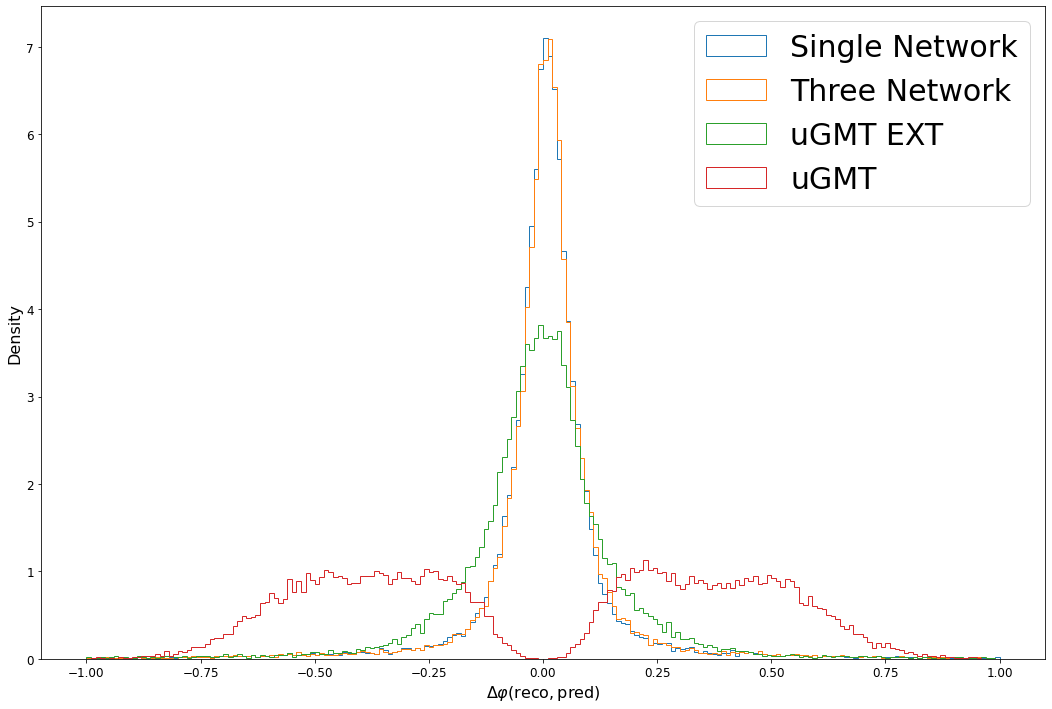

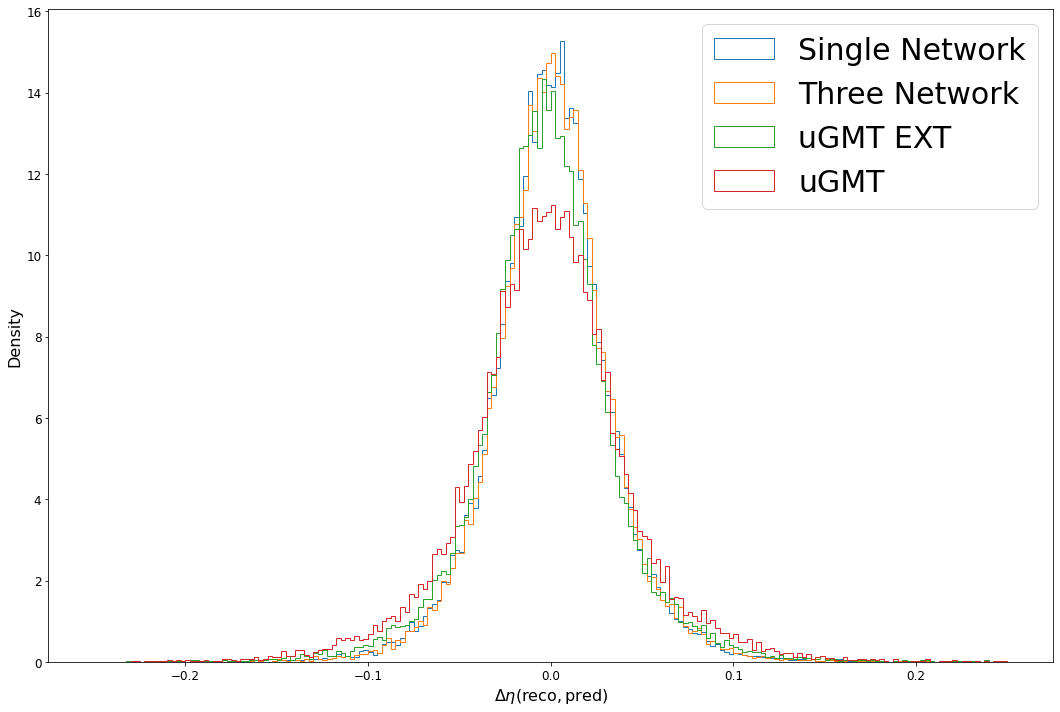

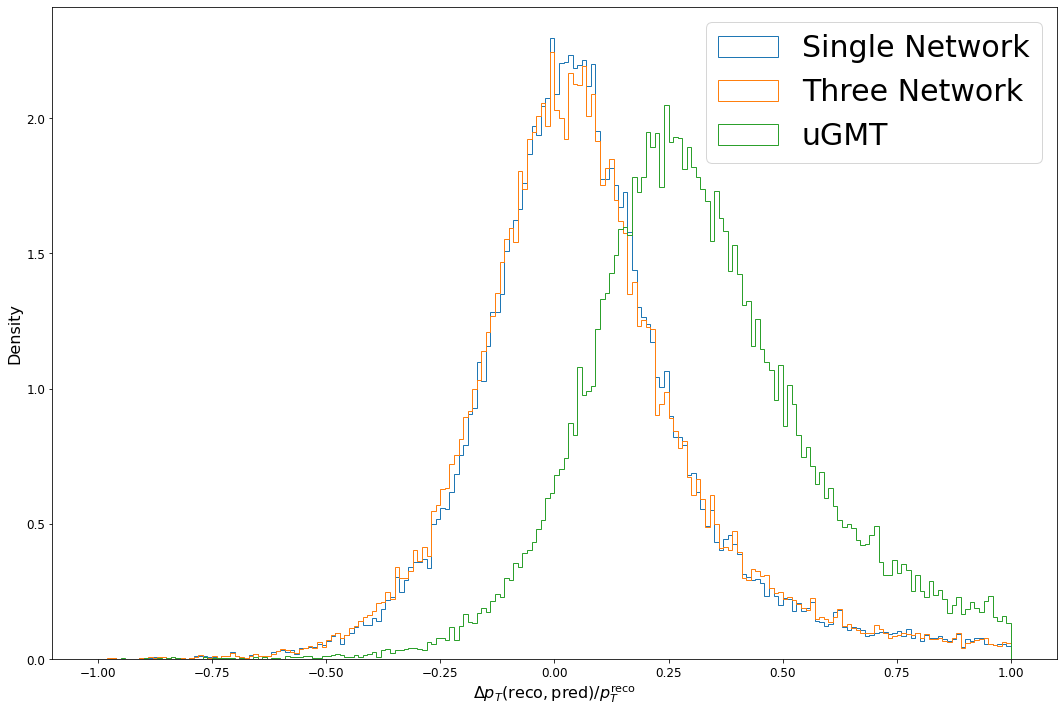

FWHM of delta_phi for the single Neural Networks 0.12300000000000011
FWHM of delta_eta for the single Neural Network 0.062000000000000166
FWHM of delta_pt for the single Neural Network 0.4130000000000005

FWHM of delta_phi for the triple Neural Network 0.12300000000000022
FWHM of delta_eta for the triple Neural Network 0.062000000000000166
FWHM of delta_pt for the triple Neural Network 0.4290000000000004


In [47]:


y_pred_1[:,0] = inv_phi_range(np.array(y_pred_1[:,0])*phi_div)
delta_phi_pred_1 = y_pred_1[:,0] * (2*math.pi / 576) 
delta_phi_pred_1 = np.array([x-2*np.pi if x > np.pi else x for x in delta_phi_pred_1])
delta_eta_pred_1 = y_pred_1[:,1] * eta_div * 0.010875
delta_pt_pred_1 =  y_pred_1[:,2] * pt_div * 0.5

y_pred_3[:,0] = inv_phi_range(np.array(y_pred_3[:,0])*phi_div)
delta_phi_pred_3 = y_pred_3[:,0] * (2*math.pi / 576) 
delta_phi_pred_3 = np.array([x-2*np.pi if x > np.pi else x for x in delta_phi_pred_3])
delta_eta_pred_3 = y_pred_3[:,1] * eta_div * 0.010875
delta_pt_pred_3 =  y_pred_3[:,2] * pt_div * 0.5


phi_pred_1 = calculate_phi(df_test['PhiL1Mu1'][:], delta_phi_pred_1[:])
eta_pred_1 = np.array(df_test['EtaL1Mu1'][:] - delta_eta_pred_1[:])
pt_pred_1= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred_1[:])

phi_pred_3 = calculate_phi(df_test['PhiL1Mu1'][:], delta_phi_pred_3[:])
eta_pred_3 = np.array(df_test['EtaL1Mu1'][:] - delta_eta_pred_3[:])
pt_pred_3= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred_3[:])



delta_phi_p_1 = calculate_phi(phi_pred_1, df_test['phiVtxRecoMu1'][:])
delta_eta_p_1 = np.array(eta_pred_1 - df_test['etaVtxRecoMu1'][:])
delta_pt_p_1 = np.array(pt_pred_1 - df_test['ptRecoMu1'][:])    

delta_phi_p_3 = calculate_phi(phi_pred_3, df_test['phiVtxRecoMu1'][:])
delta_eta_p_3 = np.array(eta_pred_3 - df_test['etaVtxRecoMu1'][:])
delta_pt_p_3 = np.array(pt_pred_3 - df_test['ptRecoMu1'][:])    


delta_phi_ext = calculate_phi(df_test['phiAtVtx1'], df_test['phiVtxRecoMu1'])
delta_eta_ext = df_test['etaAtVtx1'] - df_test['etaVtxRecoMu1']

nbins_phi = 200
nbins_eta = 200
nbins_pt  = 200

plt.figure(figsize=(18,12))
plt.hist(delta_phi_p_1,            bins=nbins_phi, range=[-1,1], alpha=1.0, histtype="step", density=True, label="Single Network")
plt.hist(delta_phi_p_3,        bins=nbins_phi, range=[-1,1], alpha=1.0, histtype="step", density=True, label="Three Network")
plt.hist(delta_phi_ext,          bins=nbins_phi, range=[-1,1], alpha=1.0, histtype="step", density=True, label="uGMT EXT")
plt.hist((df_test['deltaPhi1']), bins=nbins_phi, range=[-1,1], alpha=1.0, histtype="step", density=True, label="uGMT")
plt.xlabel("$\Delta\\varphi(\mathrm{reco},\mathrm{pred})$")
plt.ylabel("Density")
plt.legend(fontsize="30")

plt.show()
plt.figure(figsize=(18,12))
plt.hist(delta_eta_p_1,            bins=nbins_eta, range=[-0.25,0.25], alpha=1.0, histtype="step", density=True, label="Single Network")
plt.hist(delta_eta_p_3,        bins=nbins_eta, range=[-0.25,0.25], alpha=1.0, histtype="step", density=True, label="Three Network")
plt.hist(delta_eta_ext,          bins=nbins_eta, range=[-0.25,0.25], alpha=1.0, histtype="step", density=True, label="uGMT EXT")
plt.hist((df_test['deltaEta1']), bins=nbins_eta, range=[-0.25,0.25], alpha=1.0, histtype="step", density=True, label="uGMT")
plt.xlabel("$\Delta\eta(\mathrm{reco},\mathrm{pred})$")
plt.ylabel("Density")
plt.legend(fontsize="30")
# plt.savefig(os.path.join(fig_path,"eta.png"))
plt.show()
# plt.close()
plt.figure(figsize=(18,12))
plt.hist(delta_pt_p_1/df_test['ptRecoMu1'],            bins=nbins_pt, range=[-1,1], alpha=1.0, histtype="step", density=True, label="Single Network")
plt.hist(delta_pt_p_3/df_test['ptRecoMu1'],        bins=nbins_pt, range=[-1,1], alpha=1.0, histtype="step", density=True, label="Three Network")
plt.hist((df_test['deltaPt1']/df_test['ptRecoMu1']), bins=nbins_pt, range=[-1,1], alpha=1.0, histtype="step", density=True, label="uGMT")
plt.xlabel("$\Delta p_{T}(\mathrm{reco},\mathrm{pred})/p_{T}^{\mathrm{reco}}$")
plt.ylabel("Density")
plt.legend(fontsize="30")
# plt.savefig(os.path.join(fig_path,"pt.png"))
plt.show()
# plt.close()

phi_1  = delta_phi_p_1
eta_1 = delta_eta_p_1
pt_1 = np.array(delta_pt_p_1/df_test['ptRecoMu1'])


phi_3  = delta_phi_p_3
eta_3 = delta_eta_p_3
pt_3 = np.array(delta_pt_p_3/df_test['ptRecoMu1'])

print("FWHM of delta_phi for the single Neural Networks",util.find_fwhm(phi_1))
print("FWHM of delta_eta for the single Neural Network", util.find_fwhm(eta_1))
print("FWHM of delta_pt for the single Neural Network", util.find_fwhm(pt_1))
print()
print("FWHM of delta_phi for the triple Neural Network",util.find_fwhm(phi_3))
print("FWHM of delta_eta for the triple Neural Network", util.find_fwhm(eta_3))
print("FWHM of delta_pt for the triple Neural Network", util.find_fwhm(pt_3))
